In [1]:
#!/usr/bin/env python
"""
--------------------------------------------------------------------------
Created June 20, 2023 for TRIPs-Py library
"""
__author__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and "

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
from trips.operators import *
##Specify the font
##Latex needs to be installed! If not installed, please comment the following 5 lines
parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'axes.titlesize': 18, 'axes.labelsize': 18, 'figure.titlesize': 14, 'legend.fontsize': 13}
plt.rcParams.update(parameters)
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
# import phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.utilities.testProblems import *
from trips.solvers.gks_all import *
import requests
from scipy import sparse
import numpy as np
import h5py
from trips.utilities.utils import *
# functions to generate emoji data are stored in io_l.py
from trips.io import *
from trips.operators import *
from trips.solvers.AnisoTV import *
from trips.helpers import *
from scipy import sparse

ModuleNotFoundError: No module named 'trips.utilities'

# Notebook 1: Emoji test problem

<p>In this example we illustrate the following:
<p>&nbsp; Step 1: Download/read the emoji data and prepare them for processing.
<p>&nbsp; Step 2: Solve the static inverse problem.
<p>&nbsp; Step 3: Solve the dynamic inverse problem.

Emoji data are generated at the University of Helsinki: https://zenodo.org/record/1183532#.YyaW_C9h2fU


#### Step 1: Download/read the data and prepare them for processing
##### The main function to generate the emoji data is generate_emoji(dataset, noise_level) 
<p> <b>Input:</b> 
<p>&nbsp; <b>dataset:</b>
        <p>&nbsp; if dataset = 30, we generate data from DataDynamic_128x30.mat
        <p>&nbsp; if dataset = 60, we generate data from DataDynamic_128x60.mat
<p>&nbsp; <b>noise_level:</b>
        <p>&nbsp; Emoji data are real data and they have noise. Hence, we set noise_level = 0
            
<p> <b>Output:</b>  
&nbsp;<br> <b>A:</b> The full forward operator for all time instances<br>
&nbsp; <b>b:</b> All the data/measurements vectorized<br> 
&nbsp; <b>AA:</b> A list of 33 time-wise operators<br> 
&nbsp; <b>B:</b> A list of 33 data vectors for each time instance <br> 
&nbsp; <b>nx:</b> The dimension of the first spatial domain<br> 
&nbsp; <b>ny:</b> The dimension of the second spatial domain<br> 
&nbsp; <b>nt:</b> The dimension of the time instances domain<br> 
&nbsp; <b>delta:</b> The noise level in the data. When we set noise_level == 0, we get delta = 0<br> 
&nbsp; <b>sinoshape:</b> The dimension of the time-wise sinogram<br>     

In [ ]:
(A, b, AA, B, nx, ny, nt, delta) = generate_emoji(noise_level = 0.0, dataset = 30)

data already downloaded.


#### Step 2: Solve the static inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [4]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, nt)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =10, regparam = 'gcv', x_true = None)

generating basis...:   0%|          | 0/2 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


In [5]:
xx = x_mmgks.reshape((nt, nx, ny))

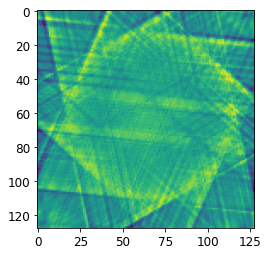

In [6]:
# xx = x_mmgks.reshape((128,128, 33))
plt.imshow(xx[1, :,:])

In [36]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = time_derivative_operator(nx, ny, 1)
# L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(AA[1], B[1].reshape((-1,1)), L, pnorm=2, qnorm=1, projection_dim=2, n_iter = 5, regparam = 1, x_true = None, delta = 0)

running MMGKS...: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


In [37]:
info_mmgks['regParam_history']

[1, 1, 1, 1, 1]

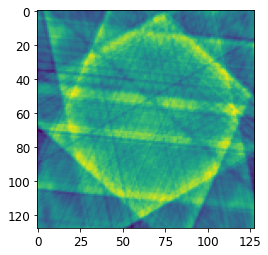

In [38]:
plt.imshow(x_mmgks.reshape((128,128)))

In [40]:
def GKS1(A, b, L, projection_dim=3, n_iter=50, regparam = 'gcv', x_true=None, **kwargs):

    dp_stop = kwargs['dp_stop'] if ('dp_stop' in kwargs) else False

    regparam_sequence = kwargs['regparam_sequence'] if ('regparam_sequence' in kwargs) else [0.1*(0.5**(x)) for x in range(0,n_iter)]

    (U, B, V) = golub_kahan(A, b, projection_dim, dp_stop, **kwargs)

    x_history = []
    lambda_history = []
    residual_history = []
    rel_error = []
    for ii in tqdm(range(n_iter), 'running GKS...'):
        
        if is_identity(L):

            Q_A, R_A, _ = la.svd(A @ V, full_matrices=False)

            R_A = np.diag(R_A)

            (Q_L, R_L) = (Identity(L.shape[0]) @ V, Identity(L.shape[0]) @ V)

        else:

            (Q_A, R_A) = la.qr(A @ V, mode='economic') # Project A into V, separate into Q and R
        
            (Q_L, R_L) = la.qr(L @ V, mode='economic') # Project L into V, separate into Q and R

        if regparam == 'gcv':
            lambdah = generalized_crossvalidation(A @ V, b, L @ V, **kwargs)#['x'].item() # find ideal lambda by crossvalidation

        elif regparam == 'dp':
            lambdah = discrepancy_principle(A @ V, b, L @ V, **kwargs)#['x'].item() # find ideal lambdas by crossvalidation

        else:
            lambdah = regparam

        lambda_history.append(lambdah)

        bhat = (Q_A.T @ b).reshape(-1,1) # Project b

        R_stacked = np.vstack( [R_A]+ [lambdah*R_L] ) # Stack projected operators

        b_stacked = np.vstack([bhat] + [np.zeros(shape=(R_L.shape[0], 1))]) # pad with zeros

        y, _,_,_ = la.lstsq(R_stacked, b_stacked) # get least squares solution

        x = V @ y # project y back

        x_history.append(x)
        # resid = la.norm(A@x - b)
        r = (A @ x).reshape(-1,1) - b.reshape(-1,1) # get residual
        residual_history.append(la.norm(r))
        ra = A.T@r
        rb = lambdah * L.T @ (L @ x)
        r = ra + rb
        r = r - V@(V.T@r)
        r = r - V@(V.T@r)
        normed_r = r / la.norm(r) # normalize residual
        V = np.hstack([V, normed_r]) # add residual to basis
        V, _ = la.qr(V, mode='economic') # orthonormalize basis using QR
    if (x_true is not None):
        if x_true.shape[1] is not 1:
            x_true = x_true.reshape(-1,1)
        x_true_norm = la.norm(x_true)
        rre_history = [la.norm(x - x_true)/x_true_norm for x in x_history]
        info = {'xHistory': x_history, 'regParam': lambdah, 'regParam_history': lambda_history, 'relError': rre_history, 'relResidual': residual_history, 'its': ii}
    else:
        info = {'xHistory': x_history, 'regParam': lambdah, 'regParam_history': lambda_history, 'relResidual': residual_history, 'its': ii}
    # info = {}
    return (x, info)

<>:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-40-74fe86197db9>:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if x_true.shape[1] is not 1:


In [11]:
b_vec = b.reshape((-1,1))
# L = spatial_derivative_operator(nx, ny, nt)
L = time_derivative_operator(nx, ny, nt)
(x_dynamic_gks, info) = GKS(A, b, L, projection_dim = 1, n_iter = 10, regparam = 'gcv', x_true = None, delta = delta)

running GKS...: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


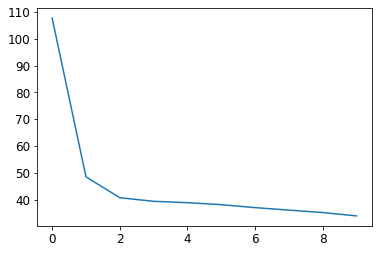

In [12]:
plt.plot(info['Residual'])

<Figure size 432x288 with 0 Axes>

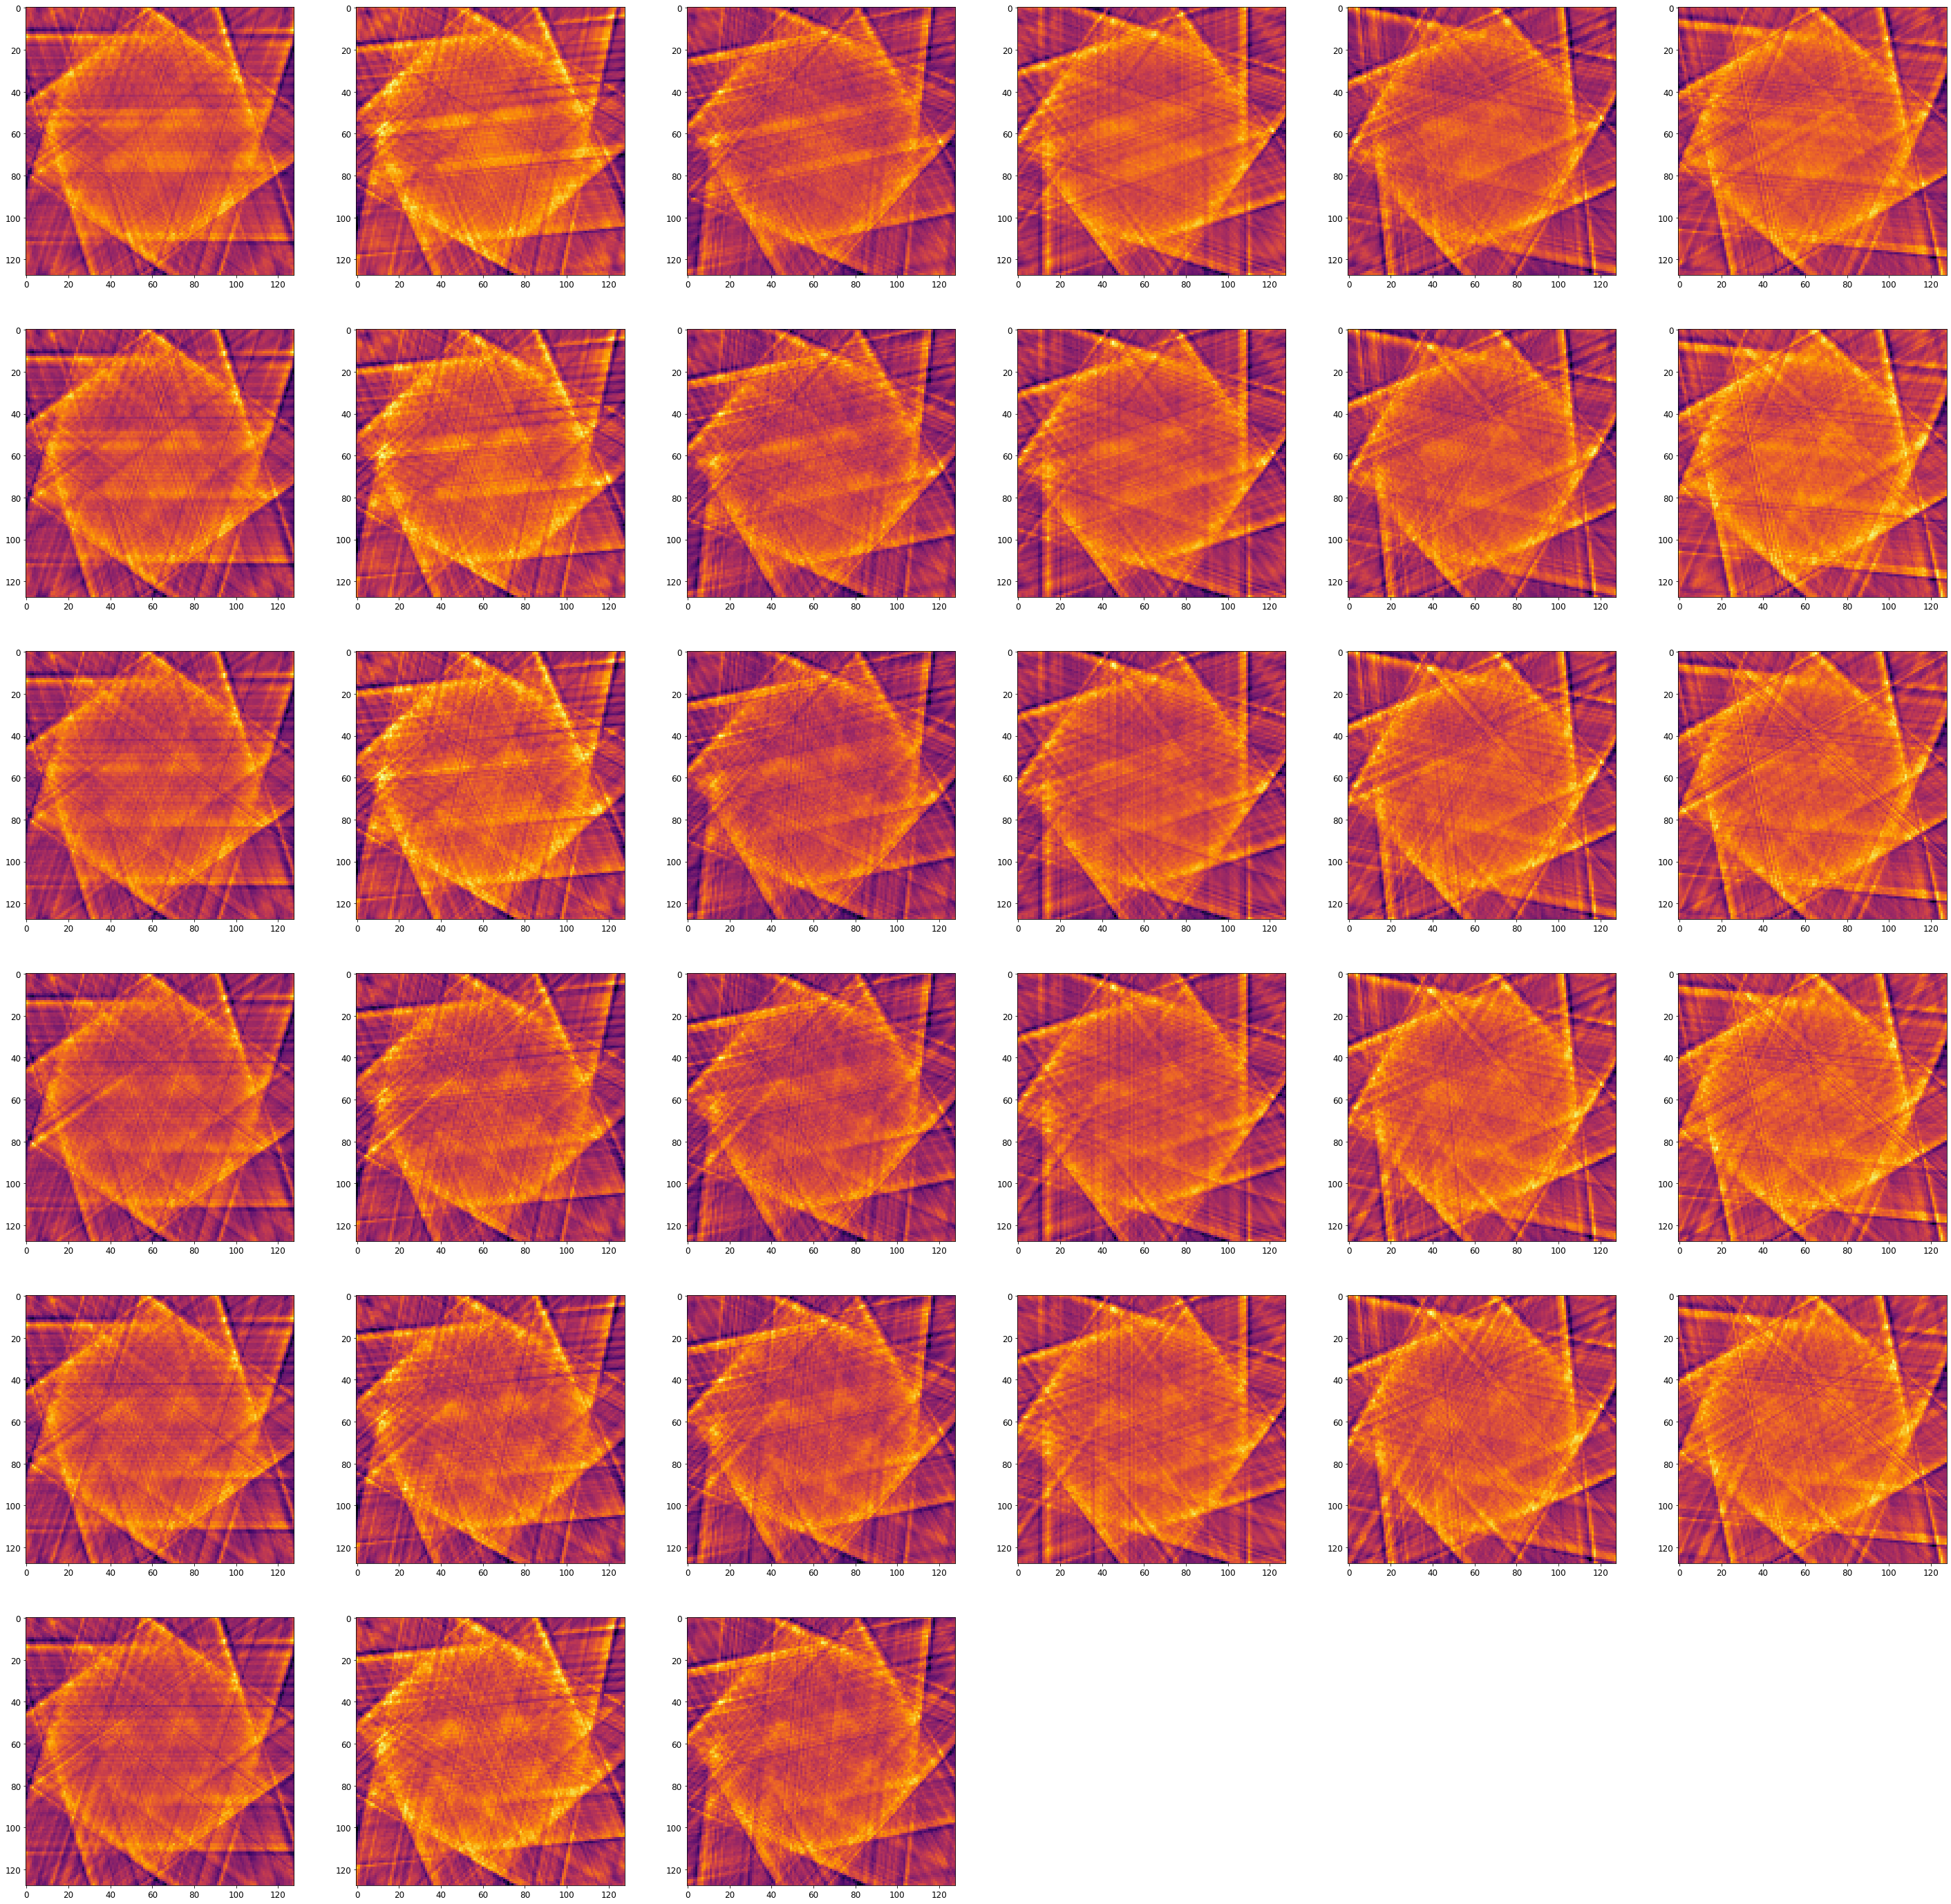

In [13]:
plot_recstructions_series(x_dynamic_gks, (nx, ny, nt), dynamic = True, testproblem = 'Emoji', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/Emoji')

In [15]:
xx = list(range(nt))
L = spatial_derivative_operator(nx, ny, 1)
for i in range(nt):
    b_vec = B[i].reshape((-1,1))
    (x_static_gks, info_gks) = GKS(AA[i], b_vec, L, pnorm=2, qnorm=1, projection_dim=1, n_iter = 2, regparam='gcv', x_true=None)
    xx[i] = x_static_gks

running GKS...: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

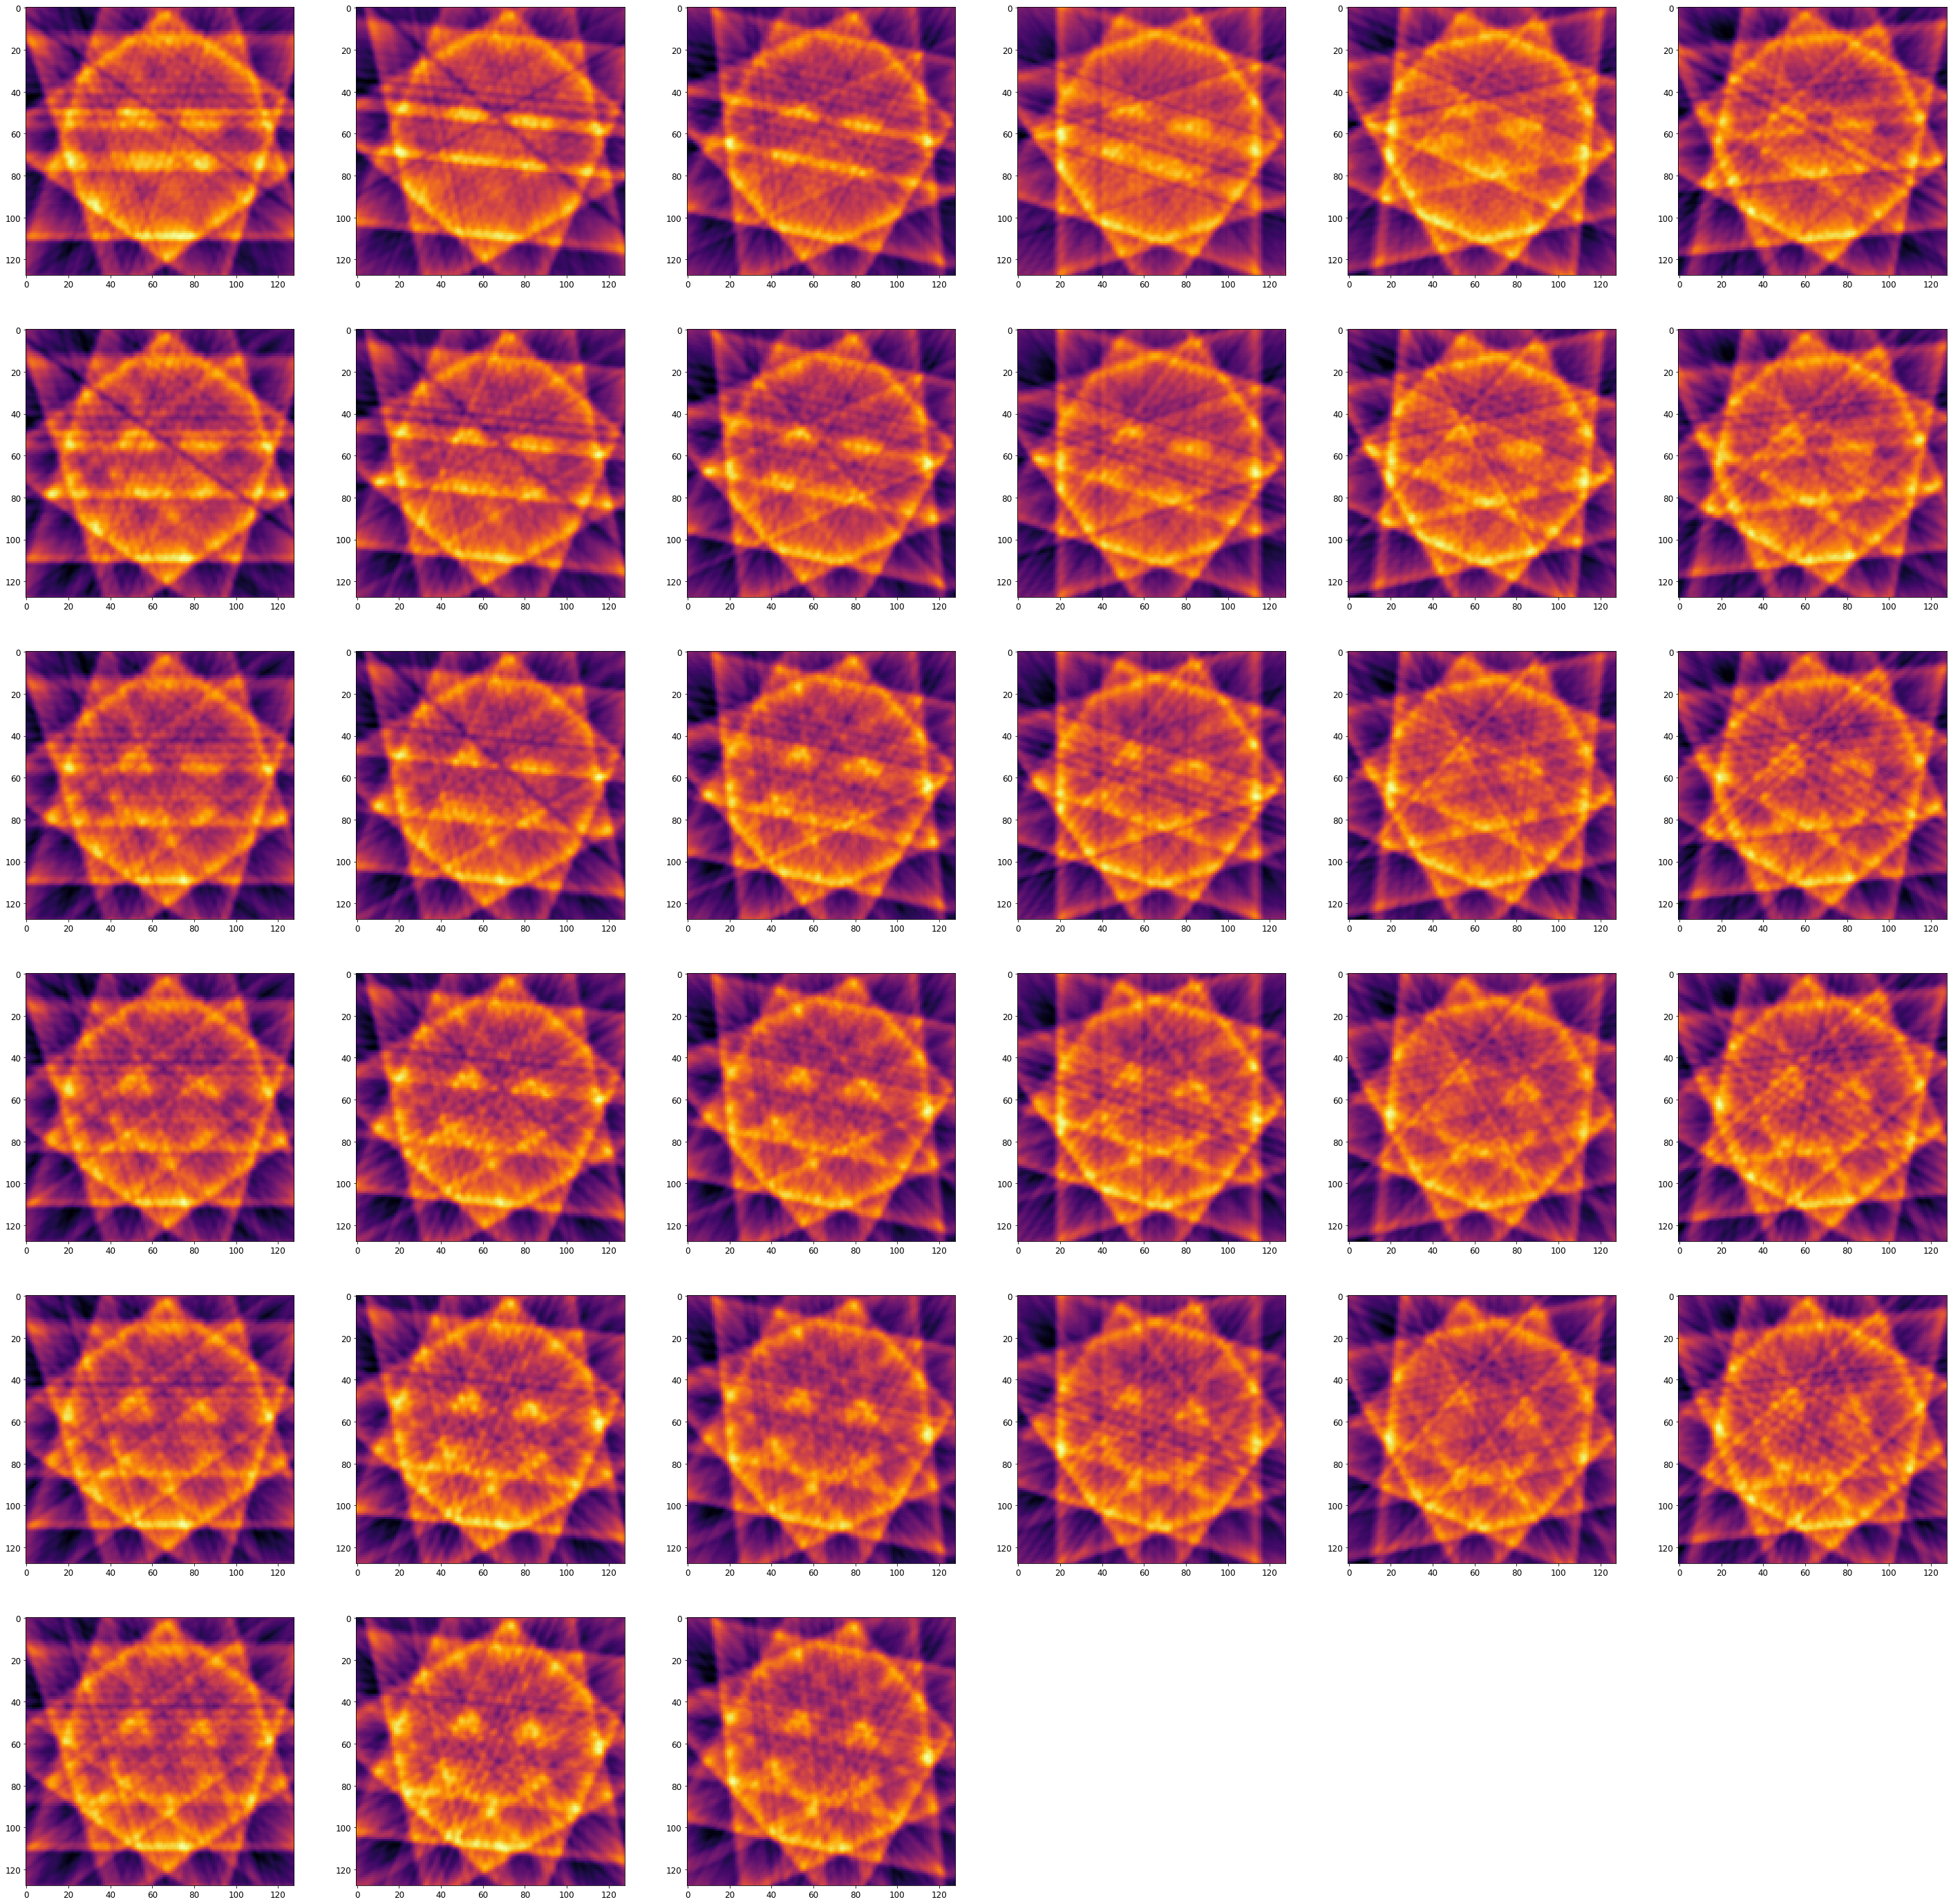

In [16]:
plot_recstructions_series(xx, (nx, ny, nt), dynamic = False, testproblem = 'Emoji', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/Emoji')

#### Step 3: Solve dynamic inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [6]:
regvals = [0.1*(0.5**(x)) for x in range(0,80)]

In [20]:
b_vec = b.reshape((-1,1))
# L = spatial_derivative_operator(nx, ny, nt)
L = time_derivative_operator(nx, ny, nt)
(x_dynamic_gks, info) = GKS(A, b, L, projection_dim = 1, n_iter = 2, regparam = 'gcv', x_true = None)

generating basis...:   0%|          | 0/1 [00:00<?, ?it/s]

running GKS...: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


<Figure size 432x288 with 0 Axes>

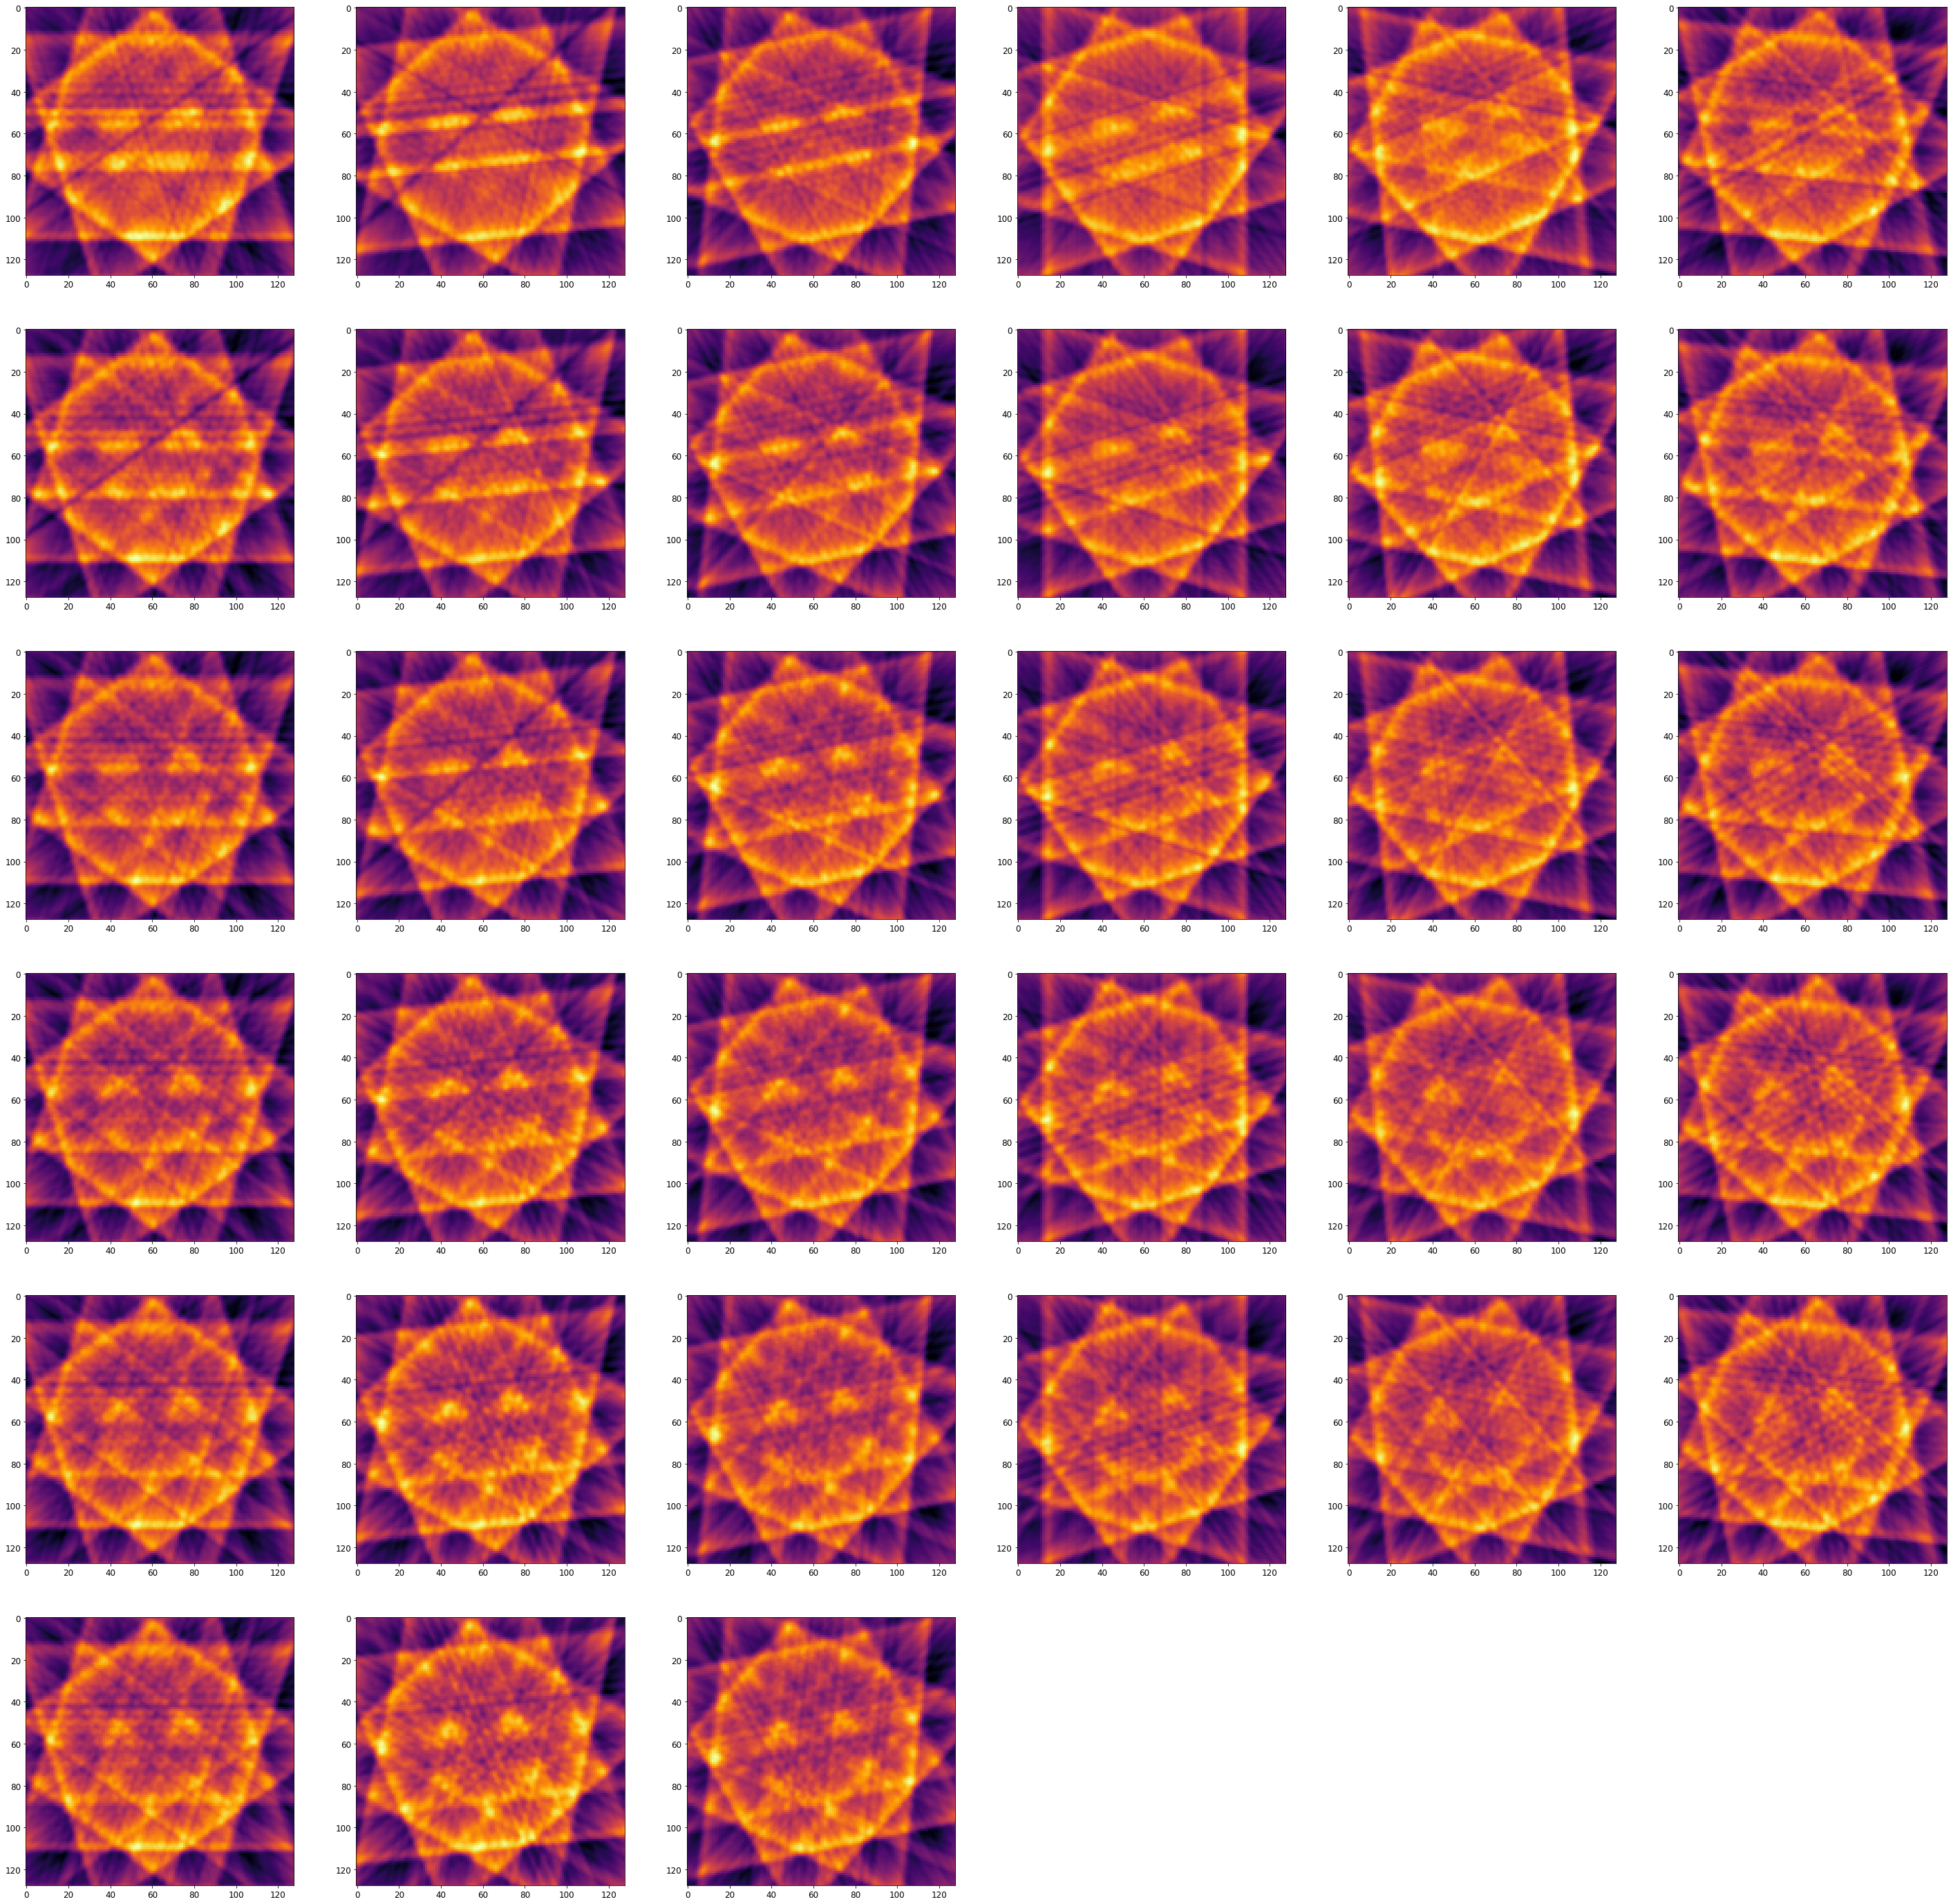

In [21]:
plot_recstructions_series(x_dynamic_gks, (nx, ny, nt), dynamic = True, testproblem = 'Emoji', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/Emoji')

#### Step 4: Solve the i-th static problem by Golub-Kahan

In [13]:
(U, Bigiag, V) = generalized_golub_kahan(AA[10], B[10], n_iter = 4, dp_stop=False)

generating basis...: 100%|██████████| 4/4 [00:00<00:00, 67.18it/s]


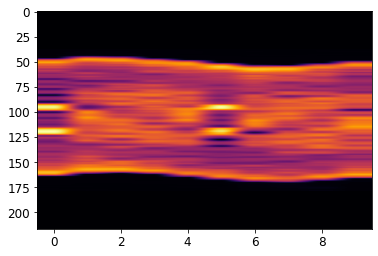

In [14]:
import matplotlib.pyplot as plt
plt.imshow(B[1].reshape(217, 10, order='F'), aspect = 'auto')

In [15]:
i = 1
b_vec = B[i].reshape((-1,1))
projection_dim = 5
(U, Bigiag, V) = golub_kahan(AA[i], b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = Bigiag[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)

generating basis...: 100%|██████████| 5/5 [00:00<00:00, 259.01it/s]


#### Step 5: Solve the dynamic problem by Golub-Kahan

In [30]:
b_vec = b.reshape((-1,1))
projection_dim = 25
(U, Bidiag, V) = golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = Bidiag[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)

generating basis...: 100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


<Figure size 432x288 with 0 Axes>

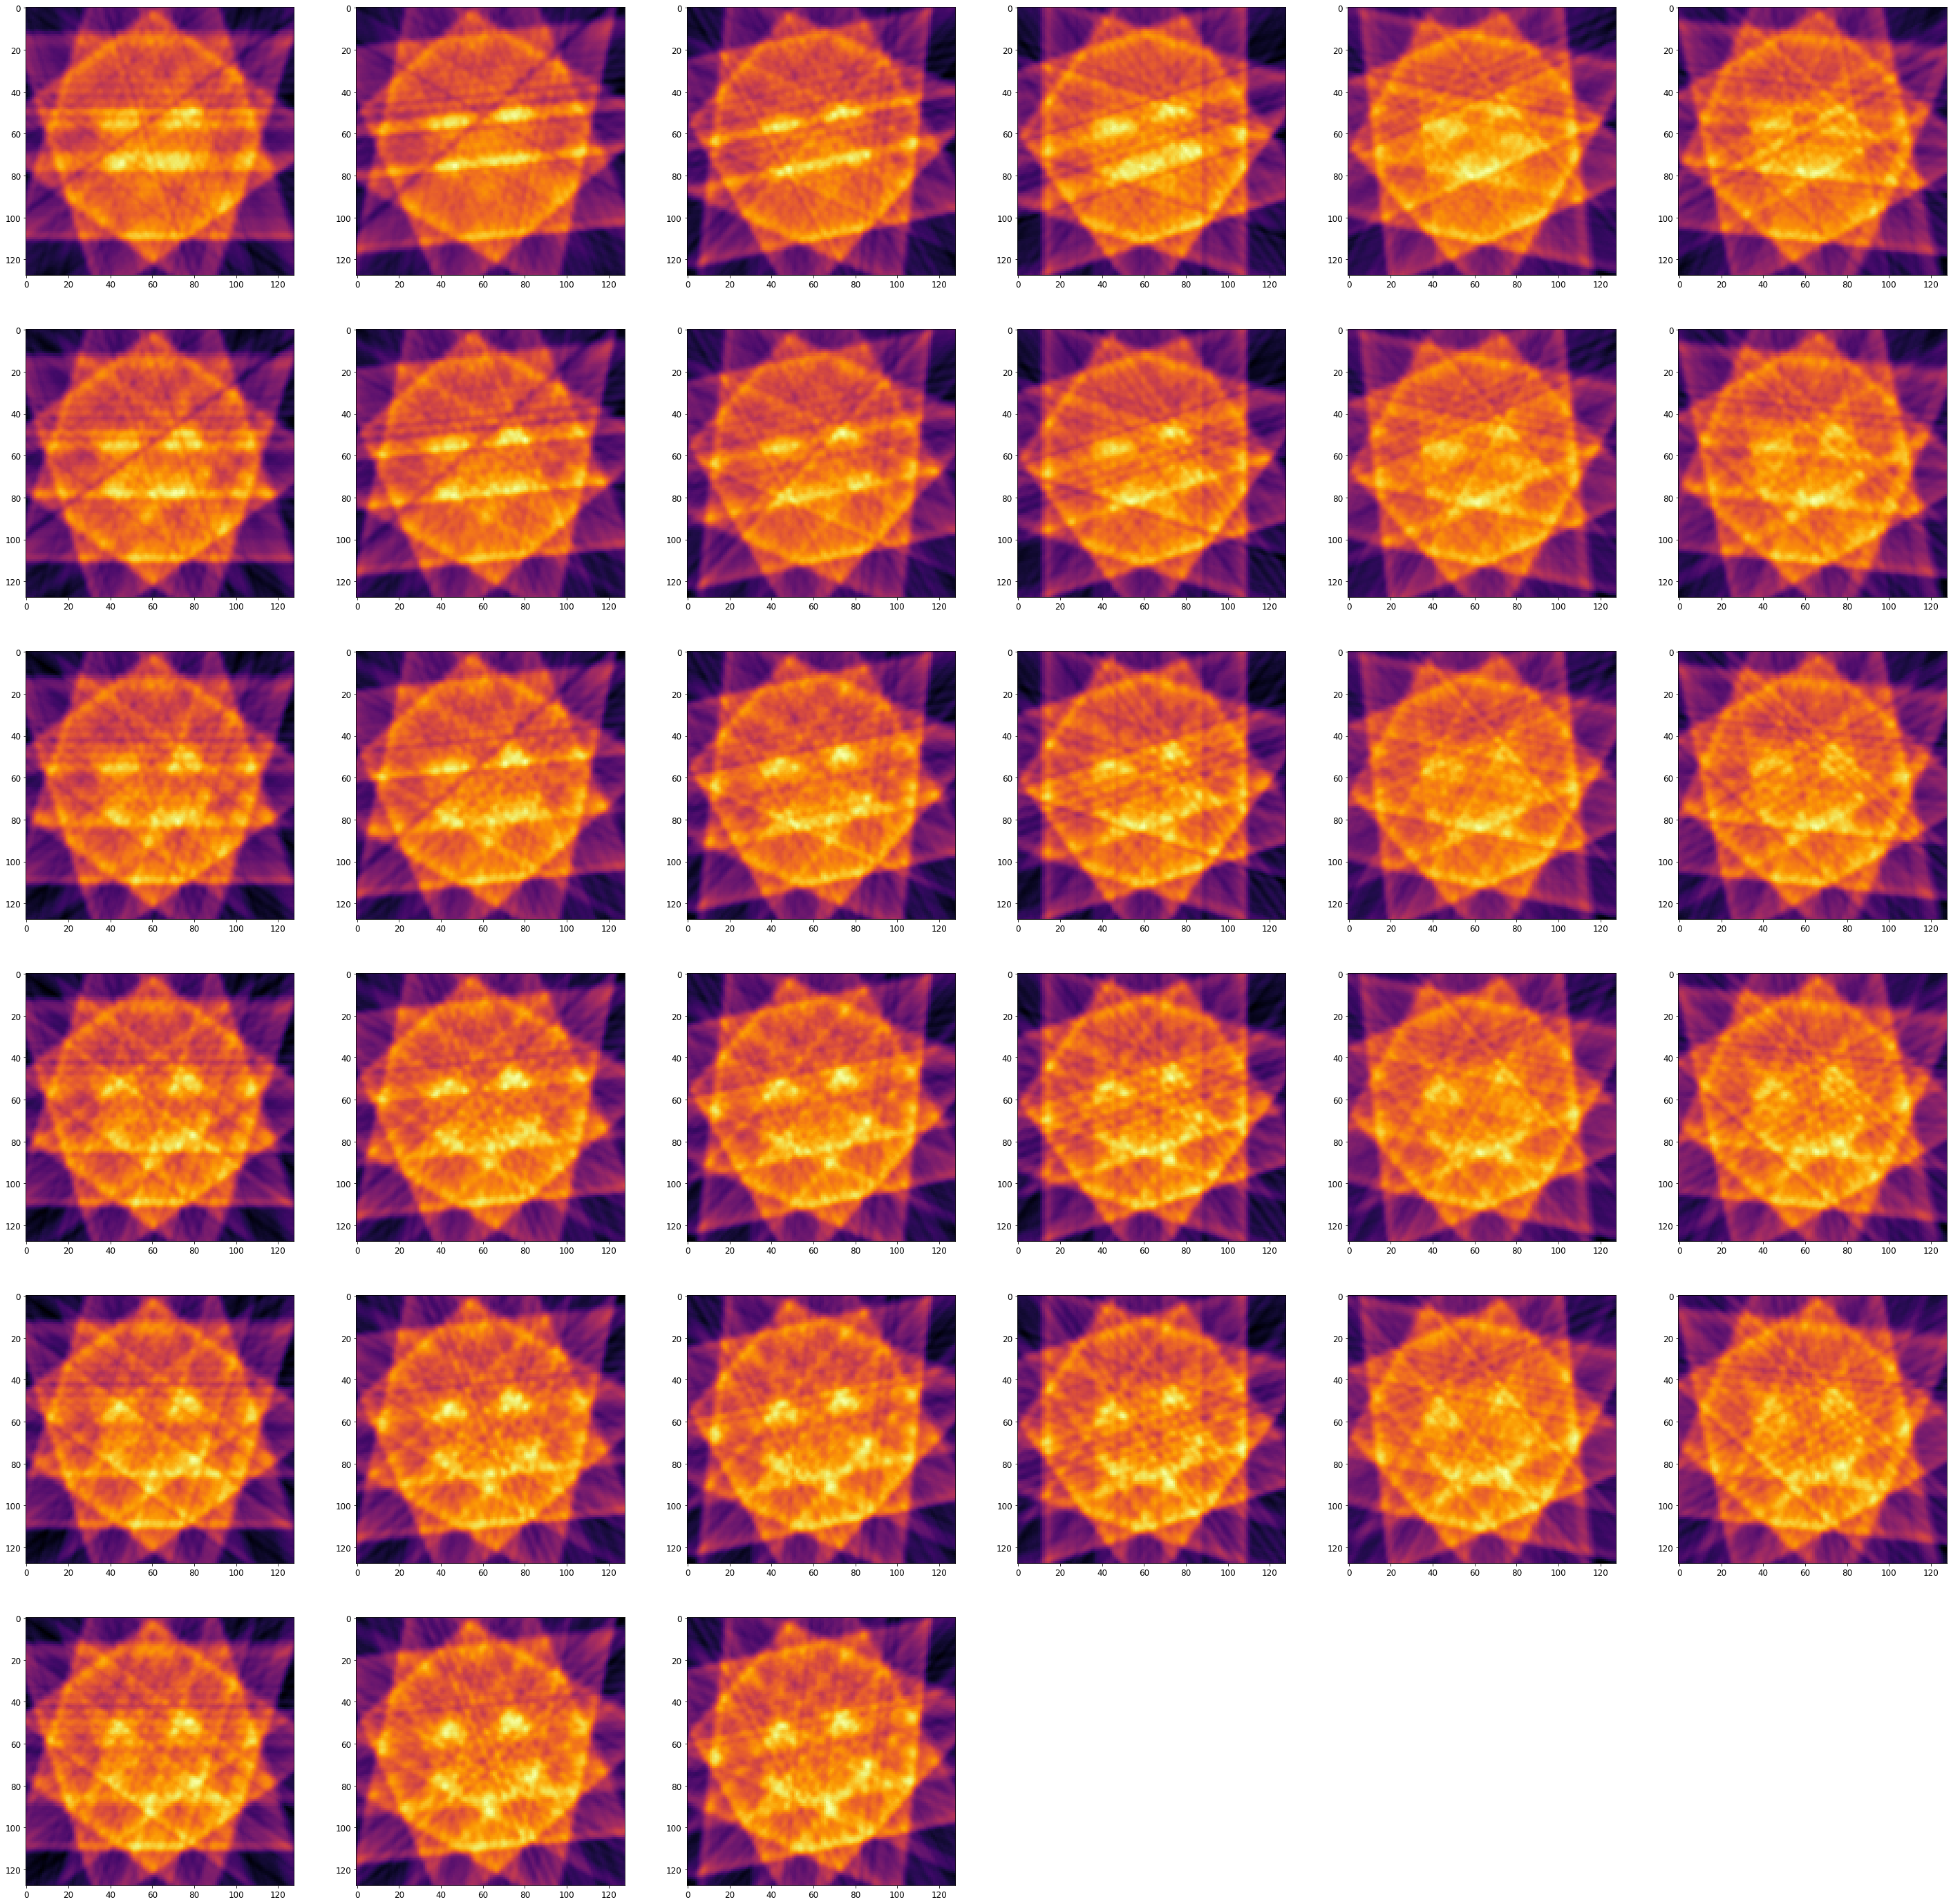

In [31]:
plot_recstructions_series(x_GKahan, (nx, ny, nt), dynamic = True, testproblem = 'emoji', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/emoji')